BASIC CNN MODEL WITH SIMPLE GRADIENT DP ALGORITHM

In [ ]:
pip install tensorflow-privacy

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Load the CIFAR10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10)
])


batch_size = 250

# Convert to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=50000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

# Parameters
l2_norm_clip = 1.0 #Limits the influence of each data point-Clips the gradients
noise_multiplier = 1.1
num_microbatches = batch_size  # Setting num_microbatches to the same size as batch_size for simplicity
learning_rate = 0.001

optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

@tf.function
def train_step(images, labels):
    logits = model(images, training=True)
    per_example_loss = loss_fn(labels, logits)
    loss_value = tf.reduce_mean(per_example_loss)

    # Use the optimizer's compute_gradients() method
    grads_and_vars = optimizer.compute_gradients(per_example_loss, model.trainable_variables)
    optimizer.apply_gradients(grads_and_vars)
    train_acc_metric(labels, logits)

    return loss_value

num_epochs = 10

# Custom training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    for step, (images, labels) in enumerate(train_dataset):
        loss_value = train_step(images, labels)
        if step % 100 == 0:
            print(f"step {step}: loss = {loss_value:.4f}")

    # Calculate and print the accumulated accuracy at the end of each epoch
    train_acc = train_acc_metric.result()
    print(f"Accuracy over epoch {epoch + 1}: {train_acc:.4f}")

    # Reset the metrics for the next epoch
    train_acc_metric.reset_states()



Epoch 1/10
step 0: loss = 2.3097
step 100: loss = 2.3109
Accuracy over epoch 1: 0.0921

Epoch 2/10
step 0: loss = 2.3250
step 100: loss = 2.3048
Accuracy over epoch 2: 0.0922

Epoch 3/10
step 0: loss = 2.3184
step 100: loss = 2.3081
Accuracy over epoch 3: 0.0924

Epoch 4/10
step 0: loss = 2.3085
step 100: loss = 2.3272
Accuracy over epoch 4: 0.0921

Epoch 5/10
step 0: loss = 2.2951
step 100: loss = 2.3201
Accuracy over epoch 5: 0.0921

Epoch 6/10
step 0: loss = 2.3099
step 100: loss = 2.3138
Accuracy over epoch 6: 0.0923

Epoch 7/10
step 0: loss = 2.3012
step 100: loss = 2.3261
Accuracy over epoch 7: 0.0923

Epoch 8/10
step 0: loss = 2.3148
step 100: loss = 2.3109
Accuracy over epoch 8: 0.0924

Epoch 9/10
step 0: loss = 2.3204
step 100: loss = 2.3105
Accuracy over epoch 9: 0.0922

Epoch 10/10
step 0: loss = 2.3068
step 100: loss = 2.3133
Accuracy over epoch 10: 0.0922


TESTING MODELS WITH RENYI-DIFFERENTIAL PRIVACY(tensorflow_privacy.DPKerasSGDOptimizer)

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import numpy as np

tf.get_logger().setLevel('ERROR')

In [ ]:
!pip install tensorflow-privacy

In [ ]:
pip install shap

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import tensorflow_privacy


# Load CIFAR-10 data
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

# Preprocess the data: normalize and reshape
train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255

train_data = train_data.reshape(train_data.shape[0], 32, 32, 3)
test_data = test_data.reshape(test_data.shape[0], 32, 32, 3)

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

# Training parameters
epochs = 3
batch_size = 250
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 250
learning_rate = 0.25

# Ensure batch_size is a multiple of num_microbatches
if batch_size % num_microbatches != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')

# Define the model architecture
model = tf.keras.Sequential([
    # Adjust the model layers to suit CIFAR-10 image dimensions and complexity
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10)
])

# Configure the differential privacy optimizer
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
model.fit(train_data, train_labels,
          epochs=epochs,
          validation_data=(test_data, test_labels),
          batch_size=batch_size)


170498071/170498071 [==============================] - 13s 0us/step
Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - ETA: 0s - loss: 2.2285 - acc: 0.1563

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


50000/50000 [==============================] - 626s 13ms/sample - loss: 2.2285 - acc: 0.1563 - val_loss: 2.0328 - val_acc: 0.2624
Epoch 2/3
50000/50000 [==============================] - 616s 12ms/sample - loss: 2.1149 - acc: 0.2304 - val_loss: 1.9480 - val_acc: 0.2984
Epoch 3/3
50000/50000 [==============================] - 616s 12ms/sample - loss: 2.0643 - acc: 0.2542 - val_loss: 1.9499 - val_acc: 0.3178


FINAL MODEL OF RDP USING CIFAR-10

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - ETA: 0s - loss: 2.1640 - acc: 0.2030

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


50000/50000 [==============================] - 193s 4ms/sample - loss: 2.1640 - acc: 0.2030 - val_loss: 1.9856 - val_acc: 0.2824
Epoch 2/3
50000/50000 [==============================] - 195s 4ms/sample - loss: 1.9789 - acc: 0.2877 - val_loss: 1.8993 - val_acc: 0.3244
Epoch 3/3
50000/50000 [==============================] - 195s 4ms/sample - loss: 1.8945 - acc: 0.3298 - val_loss: 1.8565 - val_acc: 0.3460


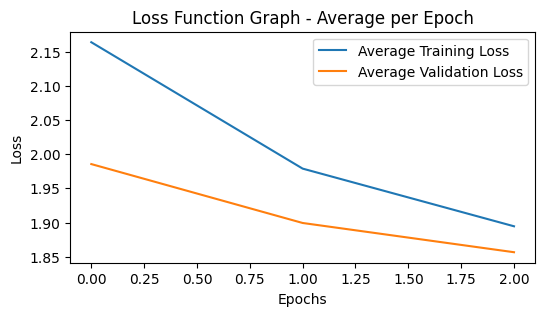

Computed epsilon: (0.5972035185419207, 17.0)


In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import tensorflow_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy
import matplotlib.pyplot as plt

# Load CIFAR-10 data
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

# Preprocess the data: normalize and reshape
train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255
train_data = train_data.reshape(train_data.shape[0], 32, 32, 3)
test_data = test_data.reshape(test_data.shape[0], 32, 32, 3)

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

# Training parameters
epochs = 3
batch_size = 250
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 250
learning_rate = 0.25

# Define the model architecture suitable for CIFAR-10
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Use DPGradientDescentGaussianOptimizer
optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)

# Compile the model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction=tf.losses.Reduction.NONE)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model and collect training history
history = model.fit(train_data, train_labels, epochs=epochs, validation_data=(test_data, test_labels), batch_size=batch_size)

# Calculate average loss and validation loss for each epoch
avg_train_loss = [np.mean(loss) for loss in history.history['loss']]
avg_val_loss = [np.mean(loss) for loss in history.history['val_loss']]

# Plot the average loss per epoch
plt.figure(figsize=(6,3))
plt.plot(avg_train_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.title('Loss Function Graph - Average per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

epsilon_cifar_10 = compute_dp_sgd_privacy(n=train_data.shape[0],
                                 batch_size=batch_size,
                                 noise_multiplier=noise_multiplier,
                                 epochs=epochs,
                                 delta=1e-5)

print(f"Computed epsilon: {epsilon_cifar_10}")


Cosine similarity: 0.9995097441298165


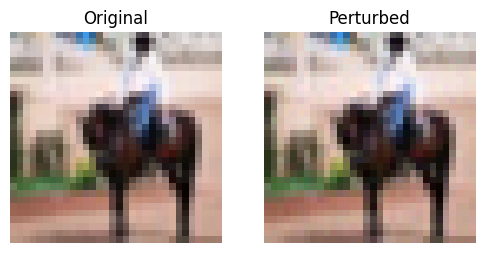

In [ ]:
import shap
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cosine

# Calculate SHAP values and return top-2 attributions for each sample
def calculate_attributions(model, data, background):
    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(data)
    shap_values = np.abs(np.array(shap_values)).mean(axis=0)
    top2_indices = np.argsort(shap_values.flatten())[-2:]  # Flatten the SHAP values to 1D and get top 2 indices
    top2_shap_values = shap_values.flatten()[top2_indices]
    return top2_shap_values

def perturb_and_get_attributions(model, data, background, std_dev=0.01):
    # Perturb data with Gaussian noise
    perturbed_data = data + np.random.normal(0, std_dev, data.shape)
    perturbed_data = np.clip(perturbed_data, 0, 1)  # Ensure valid image data
    return calculate_attributions(model, perturbed_data, background)

# Function to calculate cosine similarity between the top-2 attributions
def cosine_similarity_top2_attributions(model, original_data, background, std_dev=0.01):
    # Calculate original attributions
    original_attributions = calculate_attributions(model, original_data, background)
    # Perturb data and calculate new attributions
    perturbed_data = original_data + np.random.normal(0, std_dev, original_data.shape)
    perturbed_data = np.clip(perturbed_data, 0, 1)  # Ensure valid image data
    perturbed_attributions = calculate_attributions(model, perturbed_data, background)
    # Calculate cosine similarity (1 - cosine distance)
    similarity = 1 - cosine(original_attributions, perturbed_attributions)
    return similarity, perturbed_data

def display_images(original, perturbed):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(original.squeeze(), interpolation='nearest')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Perturbed')
    plt.imshow(perturbed.squeeze(), interpolation='nearest')
    plt.axis('off')

    plt.show()

# Select a background dataset for SHAP
background = train_data[np.random.choice(train_data.shape[0], 100, replace=False)]

# Choose an image from CIFAR-10 dataset
index = 11  # Change this index to use different images
original_image = train_data[index:index+1]  # Keep batch dimension

# Calculate cosine similarity between original and perturbed top-2 attributions
similarity, perturbed_image = cosine_similarity_top2_attributions(model, original_image, background)
print(f"Cosine similarity: {similarity}")

# Display the original and perturbed images
display_images(original_image, perturbed_image)



FINAL MODEL OF RDP USING CIFAR-100

169001437/169001437 [==============================] - 3s 0us/step
Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - ETA: 0s - loss: 4.5681 - acc: 0.0214

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


50000/50000 [==============================] - 184s 4ms/sample - loss: 4.5681 - acc: 0.0214 - val_loss: 4.5010 - val_acc: 0.0210
Epoch 2/3
50000/50000 [==============================] - 176s 4ms/sample - loss: 4.4191 - acc: 0.0306 - val_loss: 4.3527 - val_acc: 0.0344
Epoch 3/3
50000/50000 [==============================] - 176s 4ms/sample - loss: 4.3139 - acc: 0.0414 - val_loss: 4.2698 - val_acc: 0.0511


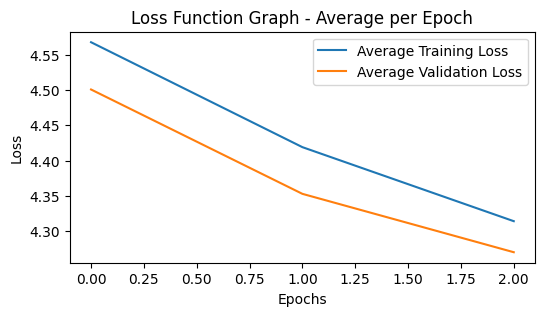

Computed epsilon: (0.5972035185419207, 17.0)


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy
import matplotlib.pyplot as plt

# Load CIFAR-100 data
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar100.load_data()

# Preprocess the data: normalize and reshape
train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255
train_data = train_data.reshape(train_data.shape[0], 32, 32, 3)
test_data = test_data.reshape(test_data.shape[0], 32, 32, 3)

# Convert labels to one-hot encoding for 100 classes
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=100)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=100)

# Training parameters
epochs = 3
batch_size = 250
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 250
learning_rate = 0.25

# Define the model architecture suitable for CIFAR-100
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(100, activation='softmax')  # Adjusted for 100 classes
])

# Use DPGradientDescentGaussianOptimizer
optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)

# Compile the model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction=tf.losses.Reduction.NONE)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model and collect training history
history = model.fit(train_data, train_labels, epochs=epochs, validation_data=(test_data, test_labels), batch_size=batch_size)

# Calculate average loss and validation loss for each epoch
avg_train_loss = [np.mean(loss) for loss in history.history['loss']]
avg_val_loss = [np.mean(loss) for loss in history.history['val_loss']]

# Plot the average loss per epoch
plt.figure(figsize=(6,3))
plt.plot(avg_train_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.title('Loss Function Graph - Average per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

epsilon_cifar_100 = compute_dp_sgd_privacy(n=train_data.shape[0],
                                 batch_size=batch_size,
                                 noise_multiplier=noise_multiplier,
                                 epochs=epochs,
                                 delta=1e-5)

print(f"Computed epsilon: {epsilon_cifar_100}")

Cosine similarity: 0.9995879178917161


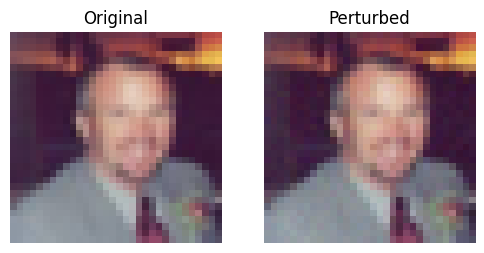

In [ ]:
import shap
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cosine

# Calculate SHAP values and return top-2 attributions for each sample
def calculate_attributions(model, data, background):
    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(data)
    shap_values = np.abs(np.array(shap_values)).mean(axis=0)
    top2_indices = np.argsort(shap_values.flatten())[-2:]  # Flatten the SHAP values to 1D and get top 2 indices
    top2_shap_values = shap_values.flatten()[top2_indices]
    return top2_shap_values

def perturb_and_get_attributions(model, data, background, std_dev=0.01):
    # Perturb data with Gaussian noise
    perturbed_data = data + np.random.normal(0, std_dev, data.shape)
    perturbed_data = np.clip(perturbed_data, 0, 1)  # Ensure valid image data
    return calculate_attributions(model, perturbed_data, background)

# Function to calculate cosine similarity between the top-2 attributions
def cosine_similarity_top2_attributions(model, original_data, background, std_dev=0.01):
    # Calculate original attributions
    original_attributions = calculate_attributions(model, original_data, background)
    # Perturb data and calculate new attributions
    perturbed_data = original_data + np.random.normal(0, std_dev, original_data.shape)
    perturbed_data = np.clip(perturbed_data, 0, 1)  # Ensure valid image data
    perturbed_attributions = calculate_attributions(model, perturbed_data, background)
    # Calculate cosine similarity (1 - cosine distance)
    similarity = 1 - cosine(original_attributions, perturbed_attributions)
    return similarity, perturbed_data

def display_images(original, perturbed):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(original.squeeze(), interpolation='nearest')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Perturbed')
    plt.imshow(perturbed.squeeze(), interpolation='nearest')
    plt.axis('off')

    plt.show()

# Select a background dataset for SHAP
background = train_data[np.random.choice(train_data.shape[0], 100, replace=False)]

# Choose an image from CIFAR-100 dataset
index = 90  # Change this index to use different images
original_image = train_data[index:index+1]  # Keep batch dimension

# Calculate cosine similarity between original and perturbed top-2 attributions
similarity, perturbed_image = cosine_similarity_top2_attributions(model, original_image, background)
print(f"Cosine similarity: {similarity}")

# Display the original and perturbed images
display_images(original_image, perturbed_image)



FINAL MODEL OF RDP USING MNIST

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 71s 1ms/sample - loss: 1.0765 - acc: 0.6600 - val_loss: 0.4871 - val_acc: 0.8556
Epoch 2/3
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.4548 - acc: 0.8794 - val_loss: 0.3479 - val_acc: 0.9164
Epoch 3/3
60000/60000 [==============================] - 64s 1ms/sample - loss: 0.3797 - acc: 0.9132 - val_loss: 0.3271 - val_acc: 0.9284


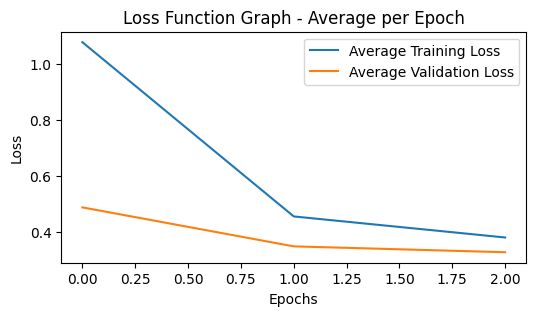

Computed epsilon: (0.5631726490328062, 18.0)


In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import tensorflow_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer

# Load MNIST data
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255
train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

# Training parameters
epochs = 3
batch_size = 250
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 250
learning_rate = 0.25

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 8,
                           strides=2,
                           padding='same',
                           activation='relu',
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Conv2D(32, 4,
                           strides=2,
                           padding='valid',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10)
])


# Use DPGradientDescentGaussianOptimizer
optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)

# Compile the model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


# Train the model and save the history
history = model.fit(train_data, train_labels, epochs=epochs, validation_data=(test_data, test_labels), batch_size=batch_size)

# Calculate average loss and validation loss for each epoch
avg_train_loss = [np.mean(loss) for loss in history.history['loss']]
avg_val_loss = [np.mean(loss) for loss in history.history['val_loss']]

# Plot the average loss per epoch
plt.figure(figsize=(6,3))
plt.plot(avg_train_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.title('Loss Function Graph - Average per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

epsilon_mnist = compute_dp_sgd_privacy(n=train_data.shape[0],
                                 batch_size=batch_size,
                                 noise_multiplier=noise_multiplier,
                                 epochs=epochs,
                                 delta=1e-5)

print(f"Computed epsilon: {epsilon_mnist}")

Cosine similarity: 0.9999734241528926


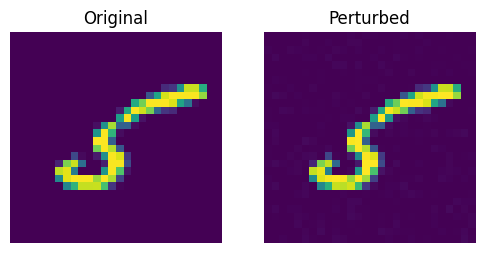

In [ ]:
import shap
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cosine

# Calculate SHAP values and return top-2 attributions for each sample
def calculate_attributions(model, data, background):
    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(data)
    shap_values = np.abs(np.array(shap_values)).mean(axis=0)
    top2_indices = np.argsort(shap_values.flatten())[-2:]  # Flatten the SHAP values to 1D and get top 2 indices
    top2_shap_values = shap_values.flatten()[top2_indices]
    return top2_shap_values

def perturb_and_get_attributions(model, data, background, std_dev=0.01):
    # Perturb data with Gaussian noise
    perturbed_data = data + np.random.normal(0, std_dev, data.shape)
    perturbed_data = np.clip(perturbed_data, 0, 1)  # Ensure valid image data
    return calculate_attributions(model, perturbed_data, background)

# Function to calculate cosine similarity between the top-2 attributions
def cosine_similarity_top2_attributions(model, original_data, background, std_dev=0.01):
    # Calculate original attributions
    original_attributions = calculate_attributions(model, original_data, background)
    # Perturb data and calculate new attributions
    perturbed_data = original_data + np.random.normal(0, std_dev, original_data.shape)
    perturbed_data = np.clip(perturbed_data, 0, 1)  # Ensure valid image data
    perturbed_attributions = calculate_attributions(model, perturbed_data, background)
    # Calculate cosine similarity (1 - cosine distance)
    similarity = 1 - cosine(original_attributions, perturbed_attributions)
    return similarity, perturbed_data

def display_images(original, perturbed):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(original.squeeze(), interpolation='nearest')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Perturbed')
    plt.imshow(perturbed.squeeze(), interpolation='nearest')
    plt.axis('off')

    plt.show()

# Select a background dataset for SHAP
background = train_data[np.random.choice(train_data.shape[0], 100, replace=False)]

# Choose an image from MNIST dataset
index = 11  # Change this index to use different images
original_image = train_data[index:index+1]  # Keep batch dimension

# Calculate cosine similarity between original and perturbed top-2 attributions
similarity, perturbed_image = cosine_similarity_top2_attributions(model, original_image, background)
print(f"Cosine similarity: {similarity}")

# Display the original and perturbed images
display_images(original_image, perturbed_image)



ANALYSIS OF PRIVACY BUDGET OF ALL THREE EPSILONS

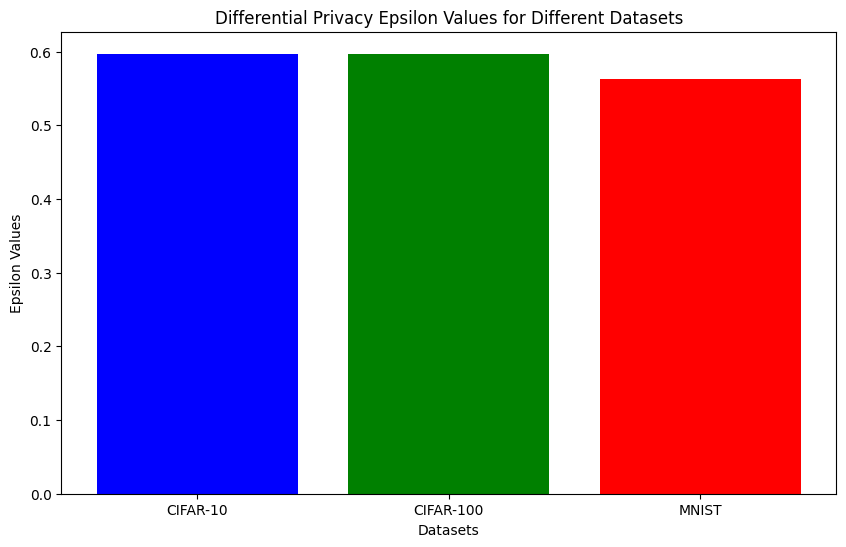

In [ ]:
import matplotlib.pyplot as plt

# Assuming epsilon_cifar_10, epsilon_cifar_100, and epsilon_mnist are tuples
epsilon_1 = epsilon_cifar_10[0]
epsilon_2 = epsilon_cifar_100[0]
epsilon_3 = epsilon_mnist[0]


# Define the datasets and their corresponding epsilon values
datasets = ['CIFAR-10', 'CIFAR-100', 'MNIST']
epsilon_values = [epsilon_1, epsilon_2, epsilon_3]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(datasets, epsilon_values, color=['blue', 'green', 'red'])
plt.xlabel('Datasets')
plt.ylabel('Epsilon Values')
plt.title('Differential Privacy Epsilon Values for Different Datasets')
plt.show()
